# FIUBA
## CEIA - Introducción a Inteligencia Artificial
## Examen
Fernando Emir Garade

**1. Responder las siguientes preguntas teóricas: link.**  

**2. Pre-procesamiento del dataset:**

    a. Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

    b. Levantar el dataset en un arreglo de Numpy. 

    c. Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

    d. Partir el dataset en train (80%) y test (20%).

**3. Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma** 

y = [Wn … W0] * [X^n    X^(n-1)    …    1]. 

    a. Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

    b. Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

    c. Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código). 

    d. Graficar el polinomio obtenido y el dataset de test. 

**4. Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).**

    a. Para cada epoch, calcular el error de train y el error de validation. 

    b. Graficar el error de train y el error de validación en función del número de epoch.

    c. Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).

**5. Para el mejor modelo seleccionado en (3c), hacer la optimización utilizando Mini-Batch y regularización Ridge.**

    a. Computar el gradiente de J y codificar en Numpy la implementación del gradiente.

    b. Comparar con el modelo obtenido en (4).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Ejercicio 2: Pre-procesamiento del dataset

### a. Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

### b. Levantar el dataset en un arreglo de Numpy. 

In [2]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('X', np.float),
                     ('y', np.float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv))
            data = np.fromiter(data_gen, structure)

        return data

    def split(self, percentage):  # 0.8
        X = self.dataset['X']
        y = self.dataset['y']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test

In [3]:
dataset = Data('data\clase_8_dataset.csv')

In [4]:
X = dataset._build_dataset('data\clase_8_dataset.csv')['X']
y = dataset._build_dataset('data\clase_8_dataset.csv')['y']

### c. Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

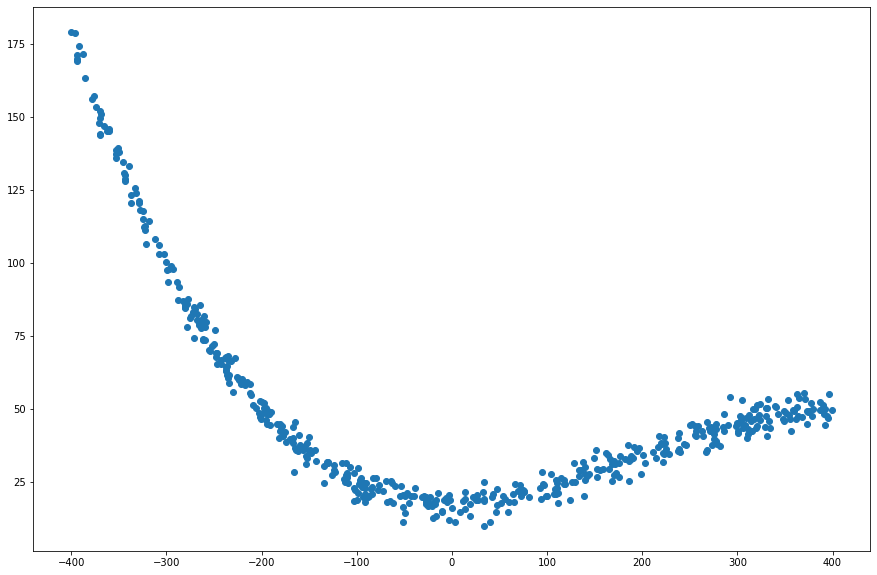

In [5]:
plt.subplots(figsize=(15,10))
plt.scatter(X, y)

### d. Partir el dataset en train (80%) y test (20%).

In [6]:
X_train, X_test, y_train, y_test = dataset.split(0.8)

## Ejercicio 3: Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma y = [Wn … W0] * [X^n    X^(n-1)    …    1].

In [7]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented

class LinearRegression(BaseModel):

    def fit(self, X, y):
        if len(X.shape) == 1:
            W = X.T.dot(y) / X.T.dot(X)
        else:
            W = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.model = W

    def predict(self, X):
        return X.dot(self.model)

In [8]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented


class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

In [9]:
def k_folds(X_train, y_train, k=5):
    l_regression = LinearRegression()
    error = MSE()
    w_list=[]

    chunk_size = int(len(X_train) / k)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression.fit(new_X_train, new_y_train)
        prediction = l_regression.predict(new_X_valid)
        w_list.append(l_regression.model)
        mse_list.append(error(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)

    #return print("MSE_promedio: ", mean_MSE), print("Mejor MSE: ", mse_list[np.argsort(mse_list)[0]]), print("Mejor W: ", w_list[np.argsort(mse_list)[0]])
    return mean_MSE, mse_list[np.argsort(mse_list)[0]], w_list[np.argsort(mse_list)[0]]

### a. Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

In [10]:
X_train_1 = np.vstack((X_train, np.ones(len(X_train)))).T

In [11]:
mean_mse1, best_mse1, best_w1 = k_folds(X_train_1, y_train, k=5)

In [12]:
print("MSE promedio: ",mean_mse1)
print("Mejor MSE: ",best_mse1)
print("Mejor W: ",best_w1)

MSE promedio:  807.4110016946006
Mejor MSE:  778.0522463339414
Mejor W:  [-0.08021356 48.6494158 ]


In [13]:
X_test_1 = np.vstack((X_test, np.ones(len(X_test)))).T

In [14]:
y_test_pred_1 = X_test_1.dot(best_w1)

In [15]:
MSE_Metric1 = MSE()

In [16]:
MSE_1 = MSE_Metric1(y_test,y_test_pred_1)
print(MSE_1)

1085.488076858754


In [17]:
X_expanded_1 = np.vstack((X, np.ones(len(X)))).T

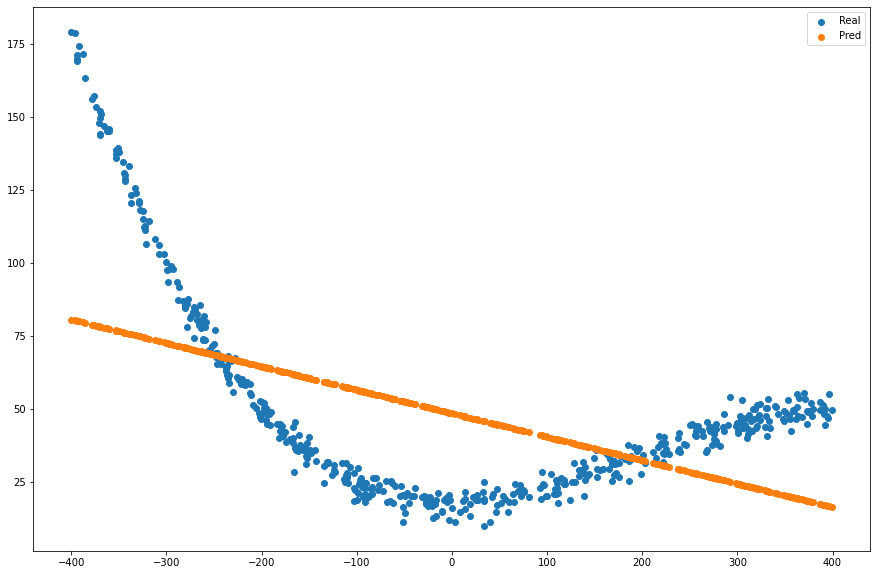

In [18]:
plt.subplots(figsize=(15,10))
plt.scatter(X, y, label='Real')
plt.scatter(X,X_expanded_1.dot(best_w1),label='Pred')
plt.legend()
plt.show()

### b. Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

In [19]:
X_train_2 = np.vstack((np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
X_train_3 = np.vstack((np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
X_train_4 = np.vstack((np.power(X_train, 4), np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T

In [20]:
X_test_2 = np.vstack((np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
X_test_3 = np.vstack((np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
X_test_4 = np.vstack((np.power(X_test, 4), np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T

In [21]:
X_2 = np.vstack((np.power(X, 2), X, np.ones(len(X)))).T
X_3 = np.vstack((np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T
X_4 = np.vstack((np.power(X, 4), np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T

In [22]:
mean_mse2, best_mse2, best_w2 = k_folds(X_train_2, y_train, k=5)
print("MSE promedio: ",mean_mse2)
print("Mejor MSE: ",best_mse2)
print("Mejor W: ",best_w2)

MSE promedio:  93.97613150742329
Mejor MSE:  81.38709587312171
Mejor W:  [ 5.92868400e-04 -9.08627241e-02  1.74321449e+01]


In [23]:
mean_mse3, best_mse3, best_w3 = k_folds(X_train_3, y_train, k=5)
print("MSE promedio: ",mean_mse3)
print("Mejor MSE: ",best_mse3)
print("Mejor W: ",best_w3)

MSE promedio:  9.384558398072688
Mejor MSE:  7.145639841982072
Mejor W:  [-1.00070060e-06  5.99407267e-04  8.21052828e-04  1.84112787e+01]


In [24]:
mean_mse4, best_mse4, best_w4 = k_folds(X_train_4, y_train, k=5)
print("MSE promedio: ",mean_mse4)
print("Mejor MSE: ",best_mse4)
print("Mejor W: ",best_w4)

MSE promedio:  9.413116164392756
Mejor MSE:  7.211991932467745
Mejor W:  [-5.33613876e-11 -1.00049951e-06  6.06448684e-04  8.28223767e-04
  1.82939276e+01]


In [25]:
y_test_pred_2 = X_test_2.dot(best_w2)
MSE_Metric2 = MSE()
MSE_2 = MSE_Metric2(y_test,y_test_pred_2)
print(MSE_2)

127.34806205573497


In [26]:
y_test_pred_3 = X_test_3.dot(best_w3)
MSE_Metric3 = MSE()
MSE_3 = MSE_Metric3(y_test,y_test_pred_3)
print(MSE_3)

11.229297848473939


In [27]:
y_test_pred_4 = X_test_4.dot(best_w4)
MSE_Metric4 = MSE()
MSE_4 = MSE_Metric4(y_test,y_test_pred_4)
print(MSE_4)

11.176327843973363


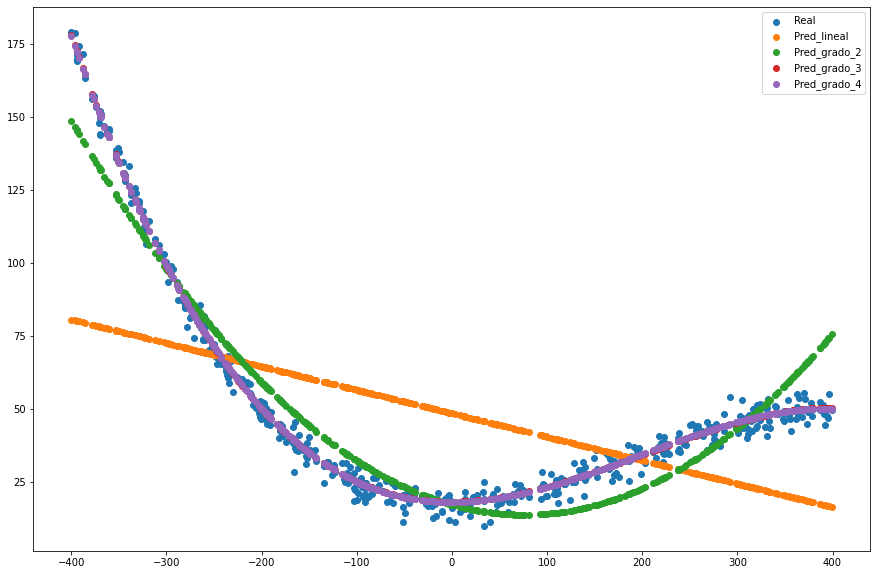

In [28]:
plt.subplots(figsize=(15,10))
plt.scatter(X, y, label='Real')
plt.scatter(X,X_expanded_1.dot(best_w1),label='Pred_lineal')
plt.scatter(X,X_2.dot(best_w2),label='Pred_grado_2')
plt.scatter(X,X_3.dot(best_w3),label='Pred_grado_3')
plt.scatter(X,X_4.dot(best_w4),label='Pred_grado_4')
plt.legend()
plt.show()

### c. Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código).

El modelo de grado 3 y 4 tienen un error cuadrático medio muy parecido. Elijo el polinomio de 3° grado ya que también es un modelo más simple.

### d. Graficar el polinomio obtenido y el dataset de test. 

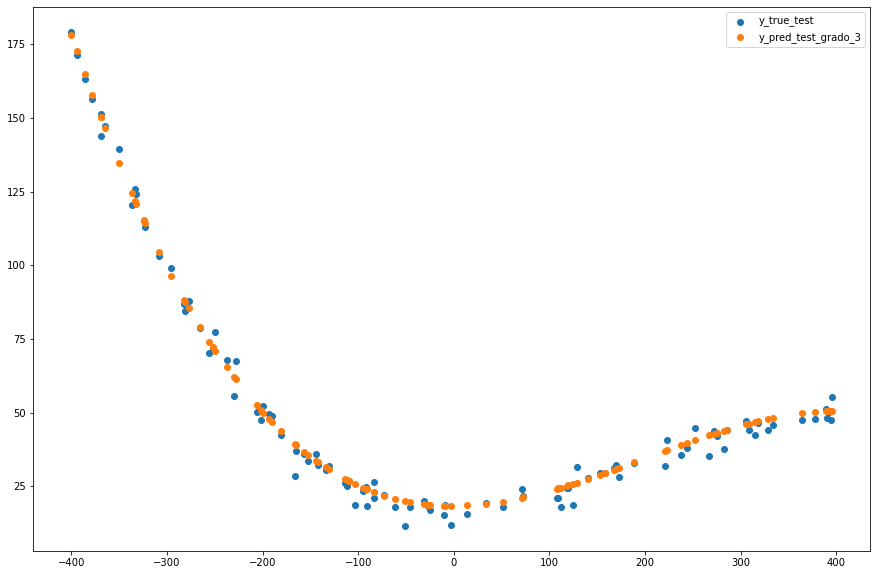

In [29]:
plt.subplots(figsize=(15,10))
plt.scatter(X_test, y_test, label='y_true_test')
plt.scatter(X_test, y_test_pred_3, label='y_pred_test_grado_3')
plt.legend()
plt.show()

## 4. Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).

In [30]:
def mini_batch_gradient_descent(X_train, X_val, y_train, y_val, lr=0.01, amt_epochs=100):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 10
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)
    w_list = []
    
    mse_train_list = []
    mse_val_list=[]
    
    MSE_Metric = MSE()

    for i in range(amt_epochs):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        batch_size = int(len(X_train) / b)
        for i in range(0, len(X_train), batch_size):
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end]
            batch_y = y_train[i: end]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(batch_X * error, axis=0)
            grad_mul = -2/n * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)
        
        w_list.append(W)
        
        prediction_train = X_train.dot(W)
        prediction_val = X_val.dot(W)
        
        mse_train_list.append(MSE_Metric(y_train, prediction_train))
        mse_val_list.append(MSE_Metric(y_val, prediction_val))
        
    return W, w_list, mse_train_list, mse_val_list

In [31]:
def train_val_split(X_train, y_train, percentage=0.8):  # 0.8
    X = X_train
    y = y_train

    # X.shape[0] -> 10 (filas)

    permuted_idxs = np.random.permutation(X.shape[0])
    # 2,1,3,4,6,7,8,5,9,0

    train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
    # permuted_idxs[0:8]
    # [2,1,3,4,5,6,7,8,5]

    test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
    # [9,0]

    X_train = X[train_idxs]
    X_val = X[test_idxs]

    y_train = y[train_idxs]
    y_val = y[test_idxs]

    return X_train, X_val, y_train, y_val

### a. Para cada epoch, calcular el error de train y el error de validation. 

In [32]:
# Estadarización 
media = X_train_3[:,:3].mean(axis=0)
desv_est = X_train_3[:,:3].std(axis=0)

In [33]:
X_train_3_estandarizado = (X_train_3[:,:3] - media) / desv_est

In [34]:
X_train_3_estandarizado = np.vstack((X_train_3_estandarizado[:,0],X_train_3_estandarizado[:,1],X_train_3_estandarizado[:,2], np.ones(len(X_train_3_estandarizado)))).T

In [35]:
X_train_3_estandarizado, X_val_3_estandarizado, y_train, y_val = train_val_split(X_train_3_estandarizado, y_train, percentage=0.8)

In [36]:
W_minibatch, w_list_minibatch, mse_train_list_minibatch, mse_val_list_minibatch = mini_batch_gradient_descent(X_train_3_estandarizado, X_val_3_estandarizado, y_train.reshape(-1,1), y_val.reshape(-1,1), lr=0.01, amt_epochs=5000)

In [37]:
W_minibatch

array([[-23.38113325],
       [ 27.20391649],
       [  0.29508866],
       [ 49.05356034]])

In [38]:
mse_train_list_minibatch[-1]

9.311325227930983

In [39]:
mse_val_list_minibatch[-1]

8.457421190444139

### b. Graficar el error de train y el error de validación en función del número de epoch.

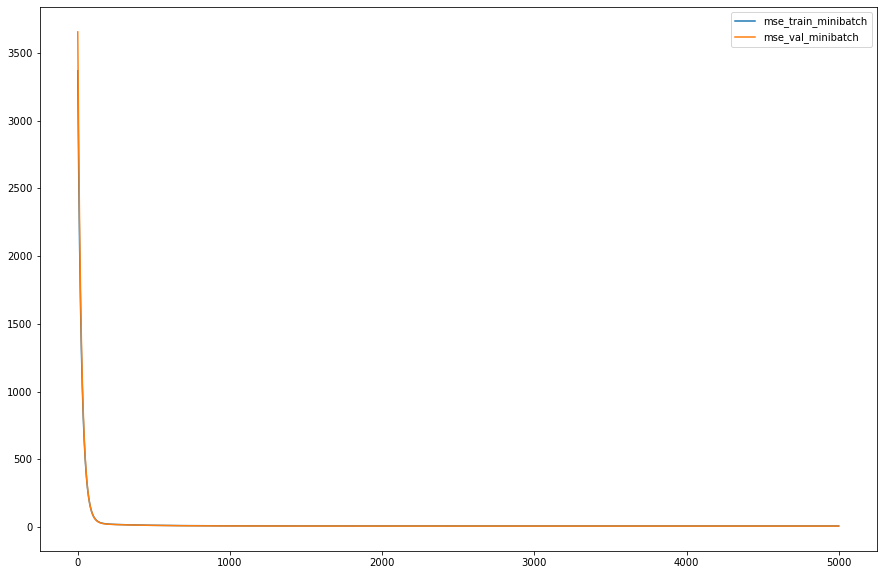

In [40]:
plt.subplots(figsize=(15,10))
plt.plot(range(len(mse_train_list_minibatch)), mse_train_list_minibatch, label='mse_train_minibatch')
plt.plot(range(len(mse_val_list_minibatch)), mse_val_list_minibatch, label='mse_val_minibatch')
plt.legend()
plt.show()

### c. Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).

In [41]:
MSE_Metric3c = MSE()
MSE_MetricMB = MSE()

In [42]:
# Solución cerrada 3c
y_test_pred_3 = X_test_3.dot(best_w3)
MSE_3 = np.sum(np.power((y_test-y_test_pred_3),2) / len(y_test))
print(MSE_3)

11.229297848473937


In [44]:
# Mini-Batch
# Estandarización de X_test_3
X_test_3_estandarizado = (X_test_3[:,:3] - media) / desv_est
X_test_3_estandarizado = np.vstack((X_test_3_estandarizado[:,0],X_test_3_estandarizado[:,1],X_test_3_estandarizado[:,2], np.ones(len(X_test_3_estandarizado)))).T

y_test_minibatch = W_minibatch.T.dot(X_test_3_estandarizado.T)
MSE_MB = MSE_MetricMB(y_test,y_test_minibatch)
print(MSE_MB)

10.90298290721178


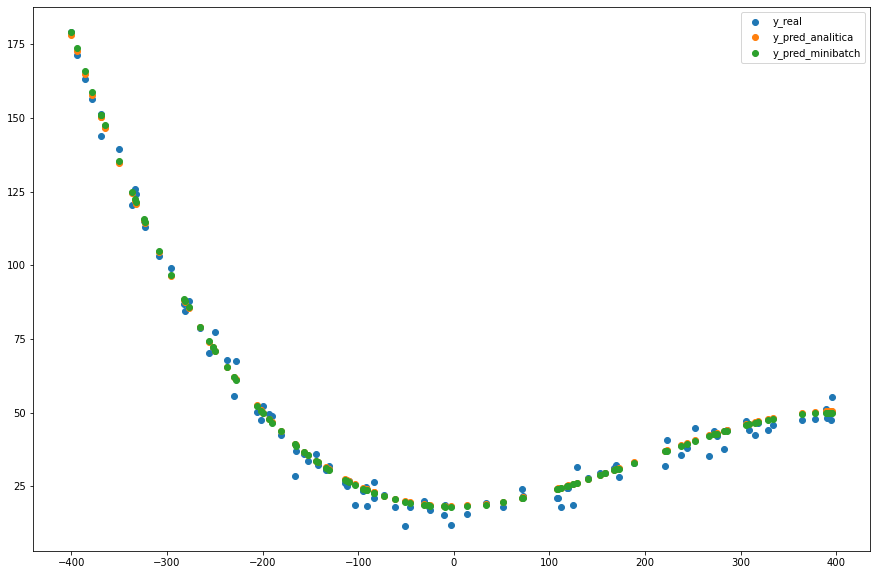

In [45]:
plt.subplots(figsize=(15,10))
plt.scatter(X_test,y_test,label='y_real')
plt.scatter(X_test_3[:,2], y_test_pred_3.reshape(-1,1), label='y_pred_analitica')
plt.scatter(X_test_3[:,2], y_test_minibatch.reshape(-1,1), label='y_pred_minibatch')
plt.legend()
plt.show()

Los errores obtenidos por el método analítico y el método numérico de minibatch son muy parecidos cuando son probados en los conjuntos de entrenamiento. Sin embargo, al probarlos con el conjunto de test, la solución numérica arroja mejores resultados. Esto puede deberse a la aleatoriedad con que fueron seleccionadas las muestras para entrenamiento.

## 5. Para el mejor modelo seleccionado en (3c), hacer la optimización utilizando Mini-Batch y regularización Ridge.

### a. Computar el gradiente de J y codificar en Numpy la implementación del gradiente.

In [54]:
def mini_batch_gradient_descent_con_ridge(X_train, X_val, y_train, y_val, lamb=0.1, lr=0.01, amt_epochs=100):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 10
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)
    w_list = []
    
    mse_train_list = []
    mse_val_list=[]
    
    MSE_Metric = MSE()

    for i in range(amt_epochs):
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        batch_size = int(len(X_train) / b)
        for i in range(0, len(X_train), batch_size):
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end]
            batch_y = y_train[i: end]

            prediction = np.matmul(batch_X, W)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(batch_X * error, axis=0)
            grad_mul = -2/n * grad_sum  # 1xm
            grad_ridge = (2 * lamb * W).reshape(1,-1) #1xm
            grad_total = grad_mul + grad_ridge
            gradient = np.transpose(grad_total).reshape(-1, 1)  # mx1

            W = W - (lr * gradient)
        
        w_list.append(W)
        
        prediction_train = X_train.dot(W)
        prediction_val = X_val.dot(W)
        
        mse_train_list.append(MSE_Metric(y_train, prediction_train))
        mse_val_list.append(MSE_Metric(y_val, prediction_val))
        
    return W, w_list, mse_train_list, mse_val_list

### b. Comparar con el modelo obtenido en (4).

In [55]:
W_ridge_minibatch_alpha_0001, w_ridge_list_minibatch_alpha_0001, mse_ridge_train_list_minibatch_alpha_0001, mse_ridge_val_list_minibatch_alpha_0001 = mini_batch_gradient_descent_con_ridge(X_train_3_estandarizado, X_val_3_estandarizado, y_train.reshape(-1,1), y_val.reshape(-1,1), lamb=0.001, lr=0.01, amt_epochs=5000)

In [56]:
W_ridge_minibatch_alpha_001, w_ridge_list_minibatch_alpha_001, mse_ridge_train_list_minibatch_alpha_001, mse_ridge_val_list_minibatch_alpha_001 = mini_batch_gradient_descent_con_ridge(X_train_3_estandarizado, X_val_3_estandarizado, y_train.reshape(-1,1), y_val.reshape(-1,1), lamb=0.01, lr=0.01, amt_epochs=5000)

In [57]:
W_ridge_minibatch_alpha_01, w_ridge_list_minibatch_alpha_01, mse_ridge_train_list_minibatch_alpha_01, mse_ridge_val_list_minibatch_alpha_01 = mini_batch_gradient_descent_con_ridge(X_train_3_estandarizado, X_val_3_estandarizado, y_train.reshape(-1,1), y_val.reshape(-1,1), lamb=0.1, lr=0.01, amt_epochs=5000)

In [58]:
MSE_Metric_ridge_MB_alpha_0001 = MSE()
y_test_ridge_minibatch_alpha_0001 = W_ridge_minibatch_alpha_0001.T.dot(X_test_3_estandarizado.T)
MSE_ridge_MB_alpha_0001 = MSE_Metric_ridge_MB_alpha_0001(y_test,y_test_ridge_minibatch_alpha_0001)
print(MSE_ridge_MB_alpha_0001)

10.684588709198767


In [59]:
MSE_Metric_ridge_MB_alpha_001 = MSE()
y_test_ridge_minibatch_alpha_001 = W_ridge_minibatch_alpha_001.T.dot(X_test_3_estandarizado.T)
MSE_ridge_MB_alpha_001 = MSE_Metric_ridge_MB_alpha_001(y_test,y_test_ridge_minibatch_alpha_001)
print(MSE_ridge_MB_alpha_001)

50.17894596220024


In [60]:
MSE_Metric_ridge_MB_alpha_01 = MSE()
y_test_ridge_minibatch_alpha_01 = W_ridge_minibatch_alpha_01.T.dot(X_test_3_estandarizado.T)
MSE_ridge_MB_alpha_01 = MSE_Metric_ridge_MB_alpha_01(y_test,y_test_ridge_minibatch_alpha_01)
print(MSE_ridge_MB_alpha_01)

1086.1373539843491


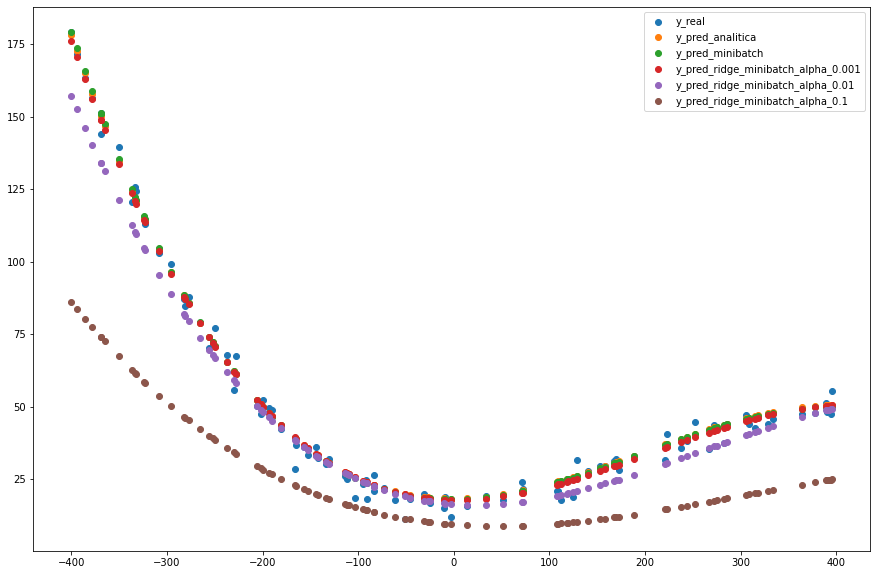

In [61]:
plt.subplots(figsize=(15,10))
plt.scatter(X_test,y_test,label='y_real')
plt.scatter(X_test_3[:,2], y_test_pred_3.reshape(-1,1), label='y_pred_analitica')
plt.scatter(X_test_3[:,2], y_test_minibatch.reshape(-1,1), label='y_pred_minibatch')
plt.scatter(X_test_3[:,2], y_test_ridge_minibatch_alpha_0001.reshape(-1,1), label='y_pred_ridge_minibatch_alpha_0.001')
plt.scatter(X_test_3[:,2], y_test_ridge_minibatch_alpha_001.reshape(-1,1), label='y_pred_ridge_minibatch_alpha_0.01')
plt.scatter(X_test_3[:,2], y_test_ridge_minibatch_alpha_01.reshape(-1,1), label='y_pred_ridge_minibatch_alpha_0.1')
plt.legend()
plt.show()

El hecho de considerar la regularización Ridge mejoró muy poco las soluciones hasta ahora obtenidas. Sí podría haber sido beneficiosa utilizar la regularización ridge desde un primer momento con variables polinómicas por ejemplo hasta el grado 10 y al calcular la regresión con regularización podríamos haber notado que a partir del 3er o 4to grado de las variables X, sus coeficientes en W tendrían pesos muy pequeños.